# BEEF example - arched 2D beam

In [45]:
from beef import fe
import beef
import numpy as np
from vispy import app, gloo
app.use_app('ipynb_webgl')
import matplotlib.pyplot as plt
from beef.newmark import factors as newmark_factors, factors_from_alpha
from copy import deepcopy

In [46]:
# Define section
A = 1.43
m = 12472.73*1.25*A
I = 115.62
E = 210e9
poisson = 0.3
rayleigh = dict(mass=1e-3, stiffness=1e-3)

section = fe.Section(E=E, m=m, I_z=I, A=A, shear_deformation=True, poisson=poisson, name='General beam section')

In [47]:
# Define geometry and mesh
n_els = 20
node_labels = np.arange(1, n_els+2)

# Bridge geometry
r = 5000.0
total_length = 5439.0

sag = r - np.sqrt(r**2 - (total_length/2)**2)
theta_tot = 2*np.arctan(0.5*total_length/(r-sag))
arc_length = theta_tot*r

startpoint = [-total_length*0.5, -sag , 0]
endpoint = [total_length*0.5, -sag , 0]

theta0 = np.pi/2 - theta_tot/2
z0 = 0
theta = np.linspace(theta0, theta0 + theta_tot, len(node_labels))

x = np.flip(r*np.cos(theta))
y = np.flip(r*np.sin(theta) - r)
z = x*0+z0

node_matrix = np.vstack([node_labels, x, y]).T
element_matrix = beef.nodes_to_beam_element_matrix(node_labels)

In [48]:
# Define part
constraints = [fe.Constraint([node_labels[0], node_labels[-1]], dofs='trans', node_type='beam2d')]
part = fe.Part(node_matrix, element_matrix, [section]*element_matrix.shape[0], constraints, constraint_type='none')
canvas, viewbox = part.plot(plot_nodes=True, node_labels=True, element_labels=True) #plot part for reference

VispyWidget(height=600, width=800)

omega_1 = 0.03630801838579108 rad/s


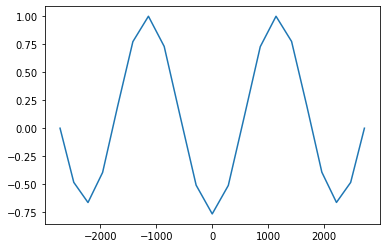

In [49]:
#%% Natural frequencies
from knutils.modal import statespace 
analysis_eig = fe.Analysis(part, forces=None)
lambd,phi = analysis_eig.run_eig()

mode_ix = 3
plt.plot(x, phi[1::3, mode_ix])
print(f'omega_1 = {np.abs(lambd[0])} rad/s')

omega_1 = 0.01815400919289554 rad/s


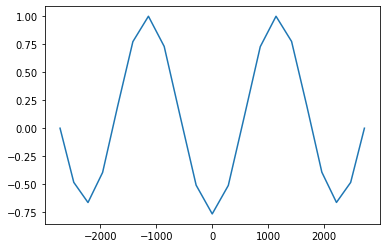

In [56]:
#%% Update section and rerun eig
part_mod = deepcopy(part)
section_mod = deepcopy(section)

section_mod.m = section_mod.m*4
part_mod.update_sections(section_mod) 

analysis_eig = fe.Analysis(part_mod, forces=None)
lambd,phi = analysis_eig.run_eig()

mode_ix = 3
plt.plot(x, phi[1::3, mode_ix])
print(f'omega_1 = {np.abs(lambd[0])} rad/s')


In [6]:
#%% Defining time axis
n_periods = 30
n_incr_per_periods = 40
mode_ix = 3

tmax = n_periods*2*np.pi/om_d[mode_ix]
n_incr = n_periods * n_incr_per_periods

dt = tmax/n_incr
t = np.arange(0, tmax+dt, dt)


In [7]:
#%% Dynamic analysis parameters
tol = dict(u=1e-1)
itmax = 20

ray_damp = 1e-3
rayleigh = dict(mass=ray_damp, stiffness=ray_damp)

# Factors for Newmark
# alpha-hht:
nmfactors = factors_from_alpha(-0.05)

# newmark_type = 'constant'
# nmfactors = newmark_factors(newmark_type)

In [8]:
#%% Excitation and analysis
q = 20e3 * np.sin(2*om_d[mode_ix]*t)

force_amplitude = q*total_length/len(node_labels)
load_nodes = node_labels
forces = [fe.Force(load_nodes, 1, force_amplitude, t=t)]
analysis_lin = fe.Analysis(part, forces, tmax=tmax, dt=dt, rayleigh=rayleigh, newmark_factors=nmfactors)
analysis_lin.run_lin_dynamic()

analysis = fe.Analysis(part, forces, tmax=tmax, dt=dt, itmax=itmax, tol=tol, rayleigh=rayleigh, newmark_factors=nmfactors)
analysis.run_dynamic()


Dynamic analysis:   0%|          | 0/1200 [00:00<?, ?it/s]

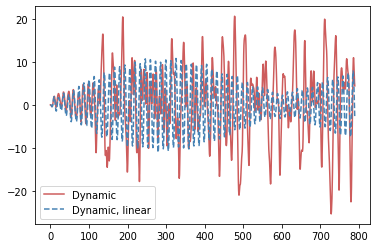

In [9]:
#%% Plotting
plt.figure(1).clf()
dof = 3

fig, ax = plt.subplots(ncols=1, nrows=1, num=1, sharex='all')
ax.plot(t, analysis.u[dof, :].T, label='Dynamic', color='IndianRed')
ax.plot(t, analysis_lin.u[dof, :].T, label='Dynamic, linear', color='SteelBlue', linestyle='--')
ax.legend()